In [24]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


import ETFs as etfs

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers



In [25]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
# display(data)


In [26]:
binary_targets = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
binary_targets.set_index('Date', inplace=True)

In [27]:
dataset_size = len(data)
train_size = int(dataset_size * 0.8)
test_size = int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

binary_targets_train = binary_targets.iloc[:train_size]
binary_targets_val = binary_targets.iloc[train_size:train_size + val_size]
binary_targets_test = binary_targets.iloc[train_size + val_size:]

In [28]:
def create_X_y_rolling(df, target_label, window_size):
    X, y, labels, first_values = [], [], [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value  
        X.append(normalized_window.values)
        
        y_target = df.iloc[i+window_size] / first_value  
        y.append(y_target.values)
        
        l = target_label.iloc[i+window_size]
        labels.append(l)
        
        first_values.append(first_value.values) 
        
    X = np.array(X)
    y = np.array(y)
    first_values = np.array(first_values)
    labels = np.array(labels)
    return X, y, first_values, labels

In [29]:
window_size = 30


X_train, y_train, first_values_train, labels_train = create_X_y_rolling(train_data, binary_targets_train, window_size)
X_val, y_val, first_values_val, labels_val = create_X_y_rolling(val_data, binary_targets_val, window_size)
X_test, y_test, first_values_test, labels_test = create_X_y_rolling(test_data, binary_targets_test, window_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, labels_train.shape, labels_val.shape, labels_test.shape


((2696, 30, 33),
 (2696, 33),
 (312, 30, 33),
 (312, 33),
 (310, 30, 33),
 (310, 33),
 (2696, 33),
 (312, 33),
 (310, 33))

In [30]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), 

    LSTM(64, return_sequences=False),
    Dropout(0.2),  

    Dense(y_train.shape[1] )
])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=[MeanSquaredError()])

cp = ModelCheckpoint(filepath='model_regression/best_LSTM.keras', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp, es],
)
# model.summary()



c:\Users\Shelly\Desktop\BachelorProject\BAvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.4275 - mean_squared_error: 0.4273 - val_loss: 0.0093 - val_mean_squared_error: 0.0092
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0042 - val_mean_squared_error: 0.0041
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0

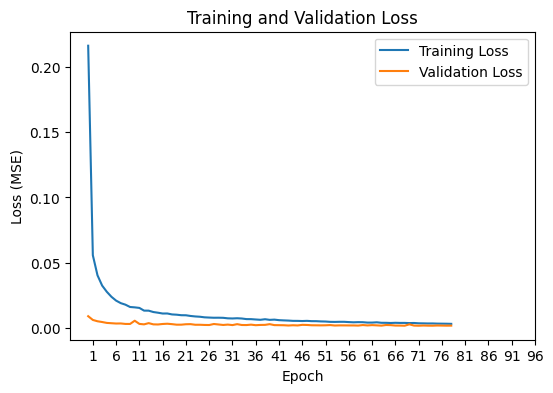

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['mean_squared_error'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
xticks = np.arange(1, 100, 5)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

In [32]:
model = load_model('model_regression/best_LSTM.keras')
index_series = data.index[-len(y_test):]  

Y_pred = model.predict(X_test)
Y_pred_denorm = Y_pred * first_values_test  

Predict_result_df = pd.DataFrame(Y_pred_denorm, index=index_series, columns=data.columns)

# display(Predict_result_df)

# Predict_result_df["SPY"].plot()


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step


In [33]:
# Y_pred

In [34]:
# SUMMARY
y_test_denorm = y_test * first_values_test
y_actual = pd.DataFrame(y_test_denorm, index=index_series, columns=data.columns)


mae = mean_absolute_error(y_test, Y_pred)
mse = mean_squared_error(y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, Y_pred)

print(f"Mean Absolute Error: {mae:.4f}" )
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error: 0.0338
Mean Squared Error: 0.0021
Root Mean Squared: 0.0462
R² Score: 0.2817


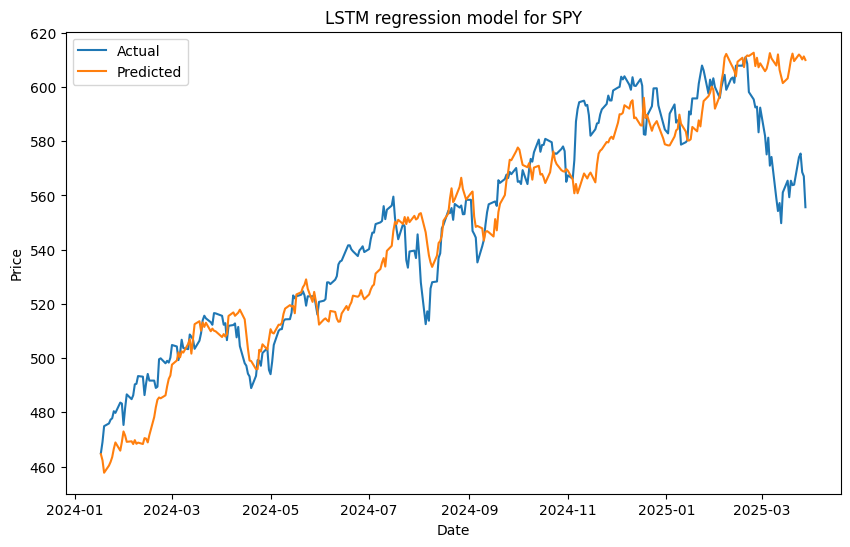

In [35]:
ticker_name = 'SPY'
plt.figure(figsize=(10,6))
plt.plot(y_actual[ticker_name], label='Actual')
plt.plot(Predict_result_df[ticker_name], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'LSTM regression model for {ticker_name}')
plt.legend()
plt.show()

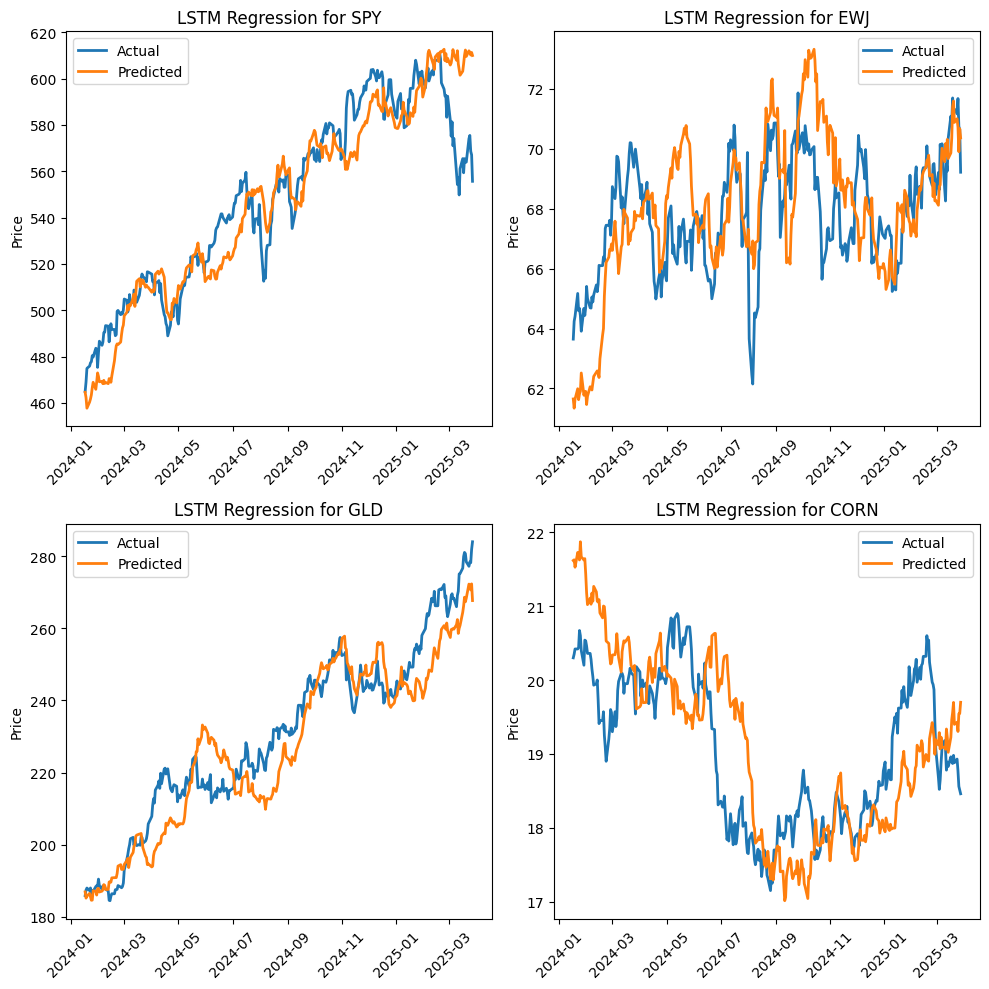

In [36]:
ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN']  

num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
axes = axes.flatten() 


for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(Predict_result_df[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'LSTM Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [37]:
# data

In [38]:
labels_test_df = pd.DataFrame(labels_test, index=index_series, columns=data.columns)
# labels_test_df

In [39]:
# display(labels_test_df["SPY"])

In [40]:
# Predict_result_df

In [41]:
y_test_shift = data[-len(y_test) - 1: -1]
y_test_shift_index = data.index[-len(y_test) - 1: -1]

y_test_shift_df = pd.DataFrame(y_test_shift, index=y_test_shift_index, columns=data.columns)
y_test_shift_array = y_test_shift_df.values


predicted_directions = (Y_pred_denorm > y_test_shift_array).astype(int)
predicted_directions_df = pd.DataFrame(predicted_directions, index=index_series, columns=data.columns)
# display(predicted_directions_df)


In [42]:
actual_flat = labels_test_df.to_numpy().flatten()
predicted_flat = predicted_directions_df.to_numpy().flatten()

matches = np.sum(actual_flat == predicted_flat)
percentage = (matches / len(actual_flat)) * 100
print(f"Match Percentage: {percentage:.2f}%")

accuracy = accuracy_score(actual_flat, predicted_flat)
print(f'Accuracy of the model: {accuracy:.4f}')

Match Percentage: 51.13%
Accuracy of the model: 0.5113
